In [3]:
import sys
from pathlib import Path

# Add project root to sys.path
proj_root = Path.cwd().parent  # Assumes notebook is in /notebooks/
if str(proj_root) not in sys.path:
    sys.path.insert(0, str(proj_root))

# Import pipeline components
from modules.model_training.training_pipeline import (
    PreprocessConfig,
    ModelSpec,
    TSNEConfig,
    hopkins_statistic,
    cluster_balance,
    make_preprocess,
    evaluate_labels,
    rank_and_score,
    run_clustering,
    plot_tsne_3d,
    plot_pca_3d
)

from modules.utils import ClusterProfiler

# Import clustering models
from sklearn.cluster import KMeans, AgglomerativeClustering
import pandas as pd
import numpy as np

try:
    import hdbscan
except ImportError:
    hdbscan = None

In [4]:
proc_df = pd.read_parquet('../data/financial_data_preprocessed_1.parquet')

#proc_df = pd.read_parquet('../data/financial_data_features_engineered.parquet')

try:
    # Create a copy to avoid modifying original
    proc_new_df = (
        proc_df
        .drop(columns=[
            # Demographic
            'age', 'gender', 'marital_status', 'education_level', 'employment_status', 
            'job_title', 
            
            # Loan
            'loan_amount_usd', 'loan_term_months', 'monthly_emi_usd', 
            'debt_to_income_ratio', 'age_bucket', 'loan_interest_rate_pct',
            'loan_type',

            # Non-Normal
            'monthly_income_usd', 'monthly_expenses_usd', 'savings_usd', 
            'deposit_interest_rate', 'responsiveness', 'borrowing_power_usd'
        ])
        .copy()
    )

    proc_new_df["has_loan"] = (
        proc_new_df["has_loan"]
        .astype(str).str.strip().str.lower()
        .map({"yes": 1, "no": 0})
        .fillna(0)
        .astype(int)
    )

except:
    proc_new_df = proc_df.copy()

In [5]:
proc_new_df_5k = proc_new_df

# HDBSCAN

In [11]:
# Best for 5K sample
{'alpha': 1.0, 'cluster_selection_epsilon': 0.1, 'cluster_selection_method': 'eom', 'metric': 'euclidean', 'min_cluster_size': 50, 'min_samples': None}  # 8 clusters 55 silhouette 6% noise
{'alpha': 1.5, 'cluster_selection_epsilon': 0.2, 'cluster_selection_method': 'leaf', 'metric': 'manhattan', 'min_cluster_size': 100, 'min_samples': 5}  # 8 clusters 52 2.5
{'alpha': 0.5, 'cluster_selection_epsilon': 0.01, 'cluster_selection_method': 'eom', 'metric': 'manhattan', 'min_cluster_size': 100, 'min_samples': 1}  # 8 clusters 52 2.4

{'alpha': 0.5,
 'cluster_selection_epsilon': 0.01,
 'cluster_selection_method': 'eom',
 'metric': 'manhattan',
 'min_cluster_size': 100,
 'min_samples': 1}

In [16]:
binary_cols = ["has_deposit", "has_loan", "has_borrowing_power"]
prob_cols = [
    "responsiveness_prob_low", "responsiveness_prob_high",
    "deposit_interest_rate_prob_very_low", "deposit_interest_rate_prob_low",
    "deposit_interest_rate_prob_high", "deposit_interest_rate_prob_very_high",
]
cont_cols = [
    "credit_score",
    "savings_to_income_ratio",
    "monthly_expenses_usd_normalized",
    "savings_usd_normalized",
    "monthly_income_usd_normalized",
    "borrowing_power_usd_normalized",
]
cat_cols = []  # add if present

binary_cols = [c for c in binary_cols if c in proc_new_df_5k.columns]
prob_cols = [c for c in prob_cols if c in proc_new_df_5k.columns]
cont_cols = [c for c in cont_cols if c in proc_new_df_5k.columns]

pre_cfg = PreprocessConfig(
    binary_cols=binary_cols,
    prob_cols=prob_cols,
    cont_cols=cont_cols,
    cat_cols=cat_cols,
    scaler = "minmax",
    row_norm = "l2",
)

# Define clustering models with hyperparameter grids
model_specs = [
    ModelSpec(
        name="hdbscan",
        factory=lambda params: hdbscan.HDBSCAN(**params),
        param_grid={
            "min_cluster_size": [100, 150, 200, 250],    # 8
            "min_samples": [None, 5, 10],                           # 6
            "cluster_selection_method": ["eom", "leaf"],                   # 2
            "metric": ["manhattan", "euclidean"],                # 3
            "alpha": [0.5, 0.75, 1.0],                            # 5
            "cluster_selection_epsilon": [0.0, 0.01],               # 3
        },
        metric="euclidean",
    )
]

results_df, artifacts = run_clustering(proc_new_df_5k, pre_cfg, model_specs, sample_n=None)
display(results_df)

# Use the best labels already computed in artifacts
# best_labels = artifacts["best_labels"]
# plot_tsne_3d(
#     artifacts["embedding"],
#     best_labels,
#     title=f"t-SNE 3D — {artifacts['best_model_name']} (score={artifacts['best']['score']:.3f})",
#     tsne_cfg=TSNEConfig(perplexity=30),
#     hover_df=proc_new_df_5k,
# )

Grid Search:   0%|          | 0/288 [00:00<?, ?it/s]

,model,params,scaler,row_norm,n_clusters,noise_frac,silhouette,calinski,davies,hopkins,balance,score
81,hdbscan,"{'alpha': 0.5, 'cluster_selection_epsilon': 0....",minmax,l2,7,0.105961,0.542785,18090.617277,0.795882,0.952961,0.817705,1.121905
273,hdbscan,"{'alpha': 1.0, 'cluster_selection_epsilon': 0....",minmax,l2,7,0.105961,0.542785,18090.617277,0.795882,0.952961,0.817705,1.121905
177,hdbscan,"{'alpha': 0.75, 'cluster_selection_epsilon': 0...",minmax,l2,7,0.105961,0.542785,18090.617277,0.795882,0.952961,0.817705,1.121905
129,hdbscan,"{'alpha': 0.75, 'cluster_selection_epsilon': 0...",minmax,l2,7,0.105961,0.542785,18090.617277,0.795882,0.952961,0.817705,1.121905
33,hdbscan,"{'alpha': 0.5, 'cluster_selection_epsilon': 0....",minmax,l2,7,0.105961,0.542785,18090.617277,0.795882,0.952961,0.817705,1.121905
...,...,...,...,...,...,...,...,...,...,...,...,...
277,hdbscan,"{'alpha': 1.0, 'cluster_selection_epsilon': 0....",minmax,l2,23,0.509511,0.307436,4640.291901,1.023530,0.945415,0.797263,0.855598
85,hdbscan,"{'alpha': 0.5, 'cluster_selection_epsilon': 0....",minmax,l2,23,0.509511,0.307436,4640.291901,1.023530,0.945415,0.797263,0.855598
229,hdbscan,"{'alpha': 1.0, 'cluster_selection_epsilon': 0....",minmax,l2,23,0.509511,0.307436,4640.291901,1.023530,0.945415,0.797263,0.855598
181,hdbscan,"{'alpha': 0.75, 'cluster_selection_epsilon': 0...",minmax,l2,23,0.509511,0.307436,4640.291901,1.023530,0.945415,0.797263,0.855598


In [ ]:
{'alpha': 0.5, 'cluster_selection_epsilon': 0.01, 'cluster_selection_method': 'eom', 'metric': 'euclidean', 'min_cluster_size': 250, 'min_samples': 10}  # 11 clusters
{'alpha': 1.0, 'cluster_selection_epsilon': 0.01, 'cluster_selection_method': 'eom', 'metric': 'euclidean', 'min_cluster_size': 200, 'min_samples': 10}  #13 clusters

In [ ]:
binary_cols = ["has_deposit", "has_loan", "has_borrowing_power"]
prob_cols = [
    "responsiveness_prob_low", "responsiveness_prob_high",
    "deposit_interest_rate_prob_very_low", "deposit_interest_rate_prob_low",
    "deposit_interest_rate_prob_high", "deposit_interest_rate_prob_very_high",
]
cont_cols = [
    "credit_score",
    "savings_to_income_ratio",
    "monthly_expenses_usd_normalized",
    "savings_usd_normalized",
    "monthly_income_usd_normalized",
    "borrowing_power_usd_normalized",
]
cat_cols = []  # add if present

binary_cols = [c for c in binary_cols if c in proc_new_df_5k.columns]
prob_cols = [c for c in prob_cols if c in proc_new_df_5k.columns]
cont_cols = [c for c in cont_cols if c in proc_new_df_5k.columns]

pre_cfg = PreprocessConfig(
    binary_cols=binary_cols,
    prob_cols=prob_cols,
    cont_cols=cont_cols,
    cat_cols=cat_cols,
    scaler = "minmax",
    row_norm = "l2",
)

# Define clustering models with hyperparameter grids
model_specs = [
    ModelSpec(
        name="hdbscan",
        factory=lambda params: hdbscan.HDBSCAN(**params),
        param_grid={
            "min_cluster_size": [200],    # 8
            "min_samples": [10],                           # 6
            "cluster_selection_method": ["eom"],                   # 2
            "metric": ["euclidean"],                # 3
            "alpha": [1.0],                            # 5
            "cluster_selection_epsilon": [0.01],               # 3
        },
        metric="euclidean",
    )
]

results_df, artifacts = run_clustering(proc_new_df_5k, pre_cfg, model_specs, sample_n=None)
display(results_df)

# Use the best labels already computed in artifacts
# best_labels = artifacts["best_labels"]
# plot_tsne_3d(
#     artifacts["embedding"],
#     best_labels,
#     title=f"t-SNE 3D — {artifacts['best_model_name']} (score={artifacts['best']['score']:.3f})",
#     tsne_cfg=TSNEConfig(perplexity=30),
#     hover_df=proc_new_df_5k,
# )

Grid Search:   0%|          | 0/1 [00:00<?, ?it/s]

,model,params,scaler,row_norm,n_clusters,noise_frac,silhouette,calinski,davies,hopkins,balance,score
0,hdbscan,"{'alpha': 1.0, 'cluster_selection_epsilon': 0....",minmax,l2,13,0.002614,0.411491,10061.998067,1.051165,0.949148,0.747577,0.975418


In [91]:
import joblib

# Save the best model (from artifacts) as a joblib file
joblib.dump(artifacts["pipeline"], "../models/best_preprocessing_pipeline.joblib")
joblib.dump(artifacts["best_params"], "../models/best_hdbscan_params.joblib")
joblib.dump(artifacts["best_model_name"], "../models/best_model_name.joblib")

# Save the fitted HDBSCAN model (refit on all data)
best_model = hdbscan.HDBSCAN(**artifacts["best_params"])
X_all = artifacts["pipeline"].transform(proc_new_df_5k)
best_model.fit(X_all)
joblib.dump(best_model, "../models/best_hdbscan_model.joblib")

['../models/best_hdbscan_model.joblib']

In [7]:
best_labels = artifacts["best_labels"]
plot_tsne_3d(
    artifacts["embedding"],
    best_labels,
    title=f"t-SNE 3D — {artifacts['best_model_name']} (score={artifacts['best']['score']:.3f})",
    tsne_cfg=TSNEConfig(perplexity=30),
    hover_df=proc_new_df_5k,
)

In [72]:
best_labels = artifacts["best_labels"]
plot_pca_3d(
    artifacts["embedding"],
    best_labels,
    title=f"PCA 3D — {artifacts['best_model_name']} (score={artifacts['best']['score']:.3f})",
    hover_df=proc_new_df_5k,
)

In [ ]:
clustered_df = proc_new_df_5k.copy()
clustered_df["cluster"] = best_labels

clustered_original_df = proc_df.copy()
clustered_original_df["cluster"] = best_labels

clustered_original_df.to_parquet('../data/financial_data_clustered.parquet', index=False)
clustered_df.to_parquet('../data/financial_data_clustered_small_feature_space.parquet', index=False)

In [ ]:
clustered_original_df.to_parquet('../data/financial_data_clustered.parquet', index=False)
clustered_df.to_parquet('../data/financial_data_clustered_small_feature_space.parquet', index=False)

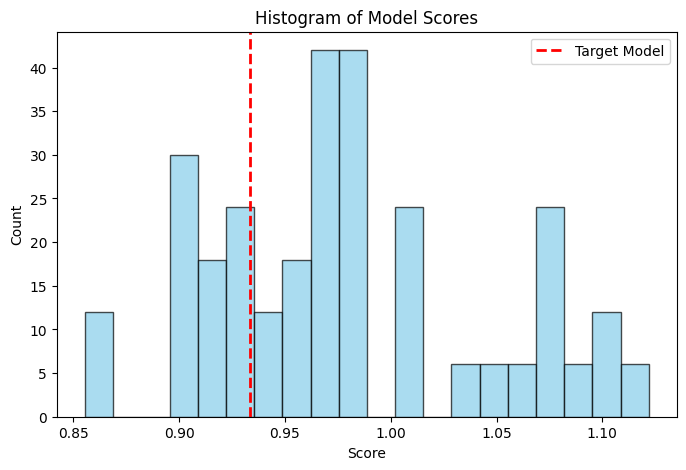

In [28]:
import ast
import matplotlib.pyplot as plt

# Load model metrics
model_metrics = pd.read_csv('../data/0_clustering_data/model_runs.csv')

# Convert the 'params' column from string to dict
model_metrics['params_dict'] = model_metrics['params'].apply(ast.literal_eval)

# Define the target params
target_params = {
    'alpha': 1.0,
    'cluster_selection_epsilon': 0.01,
    'cluster_selection_method': 'eom',
    'metric': 'euclidean',
    'min_cluster_size': 200,
    'min_samples': 10
}

# Find the row(s) matching the target params
mask = model_metrics['params_dict'].apply(lambda d: all(d.get(k) == v for k, v in target_params.items()))
matching_rows = model_metrics[mask]

# Plot histogram of 'score'
plt.figure(figsize=(8, 5))
plt.hist(model_metrics['score'].dropna(), bins=20, color='skyblue', edgecolor='black', alpha=0.7)

# Highlight the matching model(s)
for score in matching_rows['score']:
    plt.axvline(score, color='red', linestyle='--', linewidth=2, label='Target Model')

plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Histogram of Model Scores')
if not matching_rows.empty:
    plt.legend(['Target Model'])
plt.show()

In [ ]:
# ---------- usage example ----------
profiler = ClusterProfiler(proc_new_df_5k, best_labels, cluster_col="cluster", exclude={"customer_id"})
#profiler.mean_profiles()
# profiler.mean_profiles(zscore=True)
# profiler.top_feature_deviations(k=5)
# anova = profiler.anova_scores()
# # profiler.boxplots(features=["credit_score", "financial_health_score"])
# # profiler.kde_overlays(features=["financial_runway_yj", "savings_momentum_yj"])
# profiler.categorical_bars()
profiler.radar(top_n=15)

/opt/miniconda3/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning:

divide by zero encountered in divide



In [16]:
profiler.mean_profiles(zscore=False)


,has_deposit,has_loan,credit_score,savings_to_income_ratio,has_borrowing_power,monthly_expenses_usd_normalized,savings_usd_normalized,monthly_income_usd_normalized,borrowing_power_usd_normalized,responsiveness_prob_low,responsiveness_prob_high,deposit_interest_rate_prob_very_low,deposit_interest_rate_prob_low,deposit_interest_rate_prob_high,deposit_interest_rate_prob_very_high
cluster,,,,,,,,,,,,,,,
-1,0.916667,0.430556,589.750000,4.953056,1.00000,-0.040922,-0.028383,0.117433,0.699932,0.884938,0.115062,0.083333,4.330012e-01,4.836655e-01,2.613388e-23
0,1.000000,0.604938,583.209877,5.316317,0.41358,-0.051068,-0.025255,-0.073760,-0.412977,0.711747,0.288253,0.000000,9.342554e-89,3.073615e-47,1.000000e+00
1,0.000000,1.000000,570.169035,5.211656,0.00000,-0.012031,-0.011788,-0.020450,-1.239450,0.998050,0.001950,1.000000,6.406204e-15,1.077769e-23,5.229580e-57
2,0.000000,1.000000,570.151253,5.252210,0.00000,-0.004744,0.012502,-0.009506,-1.239450,0.001400,0.998600,1.000000,6.406204e-15,1.077769e-23,5.229580e-57
3,0.000000,1.000000,678.026515,4.830076,1.00000,0.303500,0.054351,0.403318,0.665251,0.998836,0.001164,1.000000,6.406204e-15,1.077769e-23,5.229580e-57
4,1.000000,0.042918,586.128755,5.118026,1.00000,0.020607,-0.001827,0.047044,0.775614,0.000241,0.999759,0.000000,3.084464e-92,1.519107e-49,1.000000e+00
5,0.000000,1.000000,683.178899,5.289541,1.00000,0.354639,0.281231,0.478294,0.666241,0.000162,0.999838,1.000000,6.406204e-15,1.077769e-23,5.229580e-57
6,1.000000,1.000000,570.731664,5.119928,0.00000,-0.067494,-0.069551,-0.105278,-1.239450,0.999129,0.000871,0.000000,5.638725e-01,4.361275e-01,1.611633e-18
7,1.000000,1.000000,564.802276,5.305220,0.00000,0.000274,0.021186,-0.015405,-1.239450,0.001246,0.998754,0.000000,6.335728e-01,3.664272e-01,3.226309e-17


In [30]:
means_df

,has_deposit,has_loan,credit_score,savings_to_income_ratio,has_borrowing_power,monthly_expenses_usd_normalized,savings_usd_normalized,monthly_income_usd_normalized,borrowing_power_usd_normalized,responsiveness_prob_low,responsiveness_prob_high,deposit_interest_rate_prob_very_low,deposit_interest_rate_prob_low,deposit_interest_rate_prob_high,deposit_interest_rate_prob_very_high
cluster,,,,,,,,,,,,,,,
-1,2.170449,0.062160,0.094746,-0.092230,0.782491,-0.040921,-0.028383,0.117431,0.699920,0.752354,-0.752354,-2.170449,1.429518,2.121248,-0.163702
0,2.405553,0.418096,0.053540,0.039283,-0.425777,-0.051067,-0.025254,-0.073758,-0.412970,0.405024,-0.405024,-2.405553,-0.288898,-0.236131,6.108434
1,-0.415690,1.224463,-0.028623,0.001392,-1.277924,-0.012030,-0.011788,-0.020449,-1.239427,0.979197,-0.979197,0.415690,-0.288898,-0.236131,-0.163702
2,-0.415690,1.224463,-0.028735,0.016075,-1.277924,-0.004744,0.012502,-0.009506,-1.239427,-1.019561,1.019561,0.415690,-0.288898,-0.236131,-0.163702
3,-0.415690,1.224463,0.650925,-0.136753,0.782491,0.303494,0.054350,0.403311,0.665239,0.980775,-0.980775,0.415690,-0.288898,-0.236131,-0.163702
4,2.405553,-0.729053,0.071930,-0.032505,0.782491,0.020607,-0.001827,0.047043,0.775600,-1.021884,1.021884,-2.405553,-0.288898,-0.236131,6.108434
5,-0.415690,1.224463,0.683388,0.029590,0.782491,0.354632,0.281226,0.478285,0.666229,-1.022043,1.022043,0.415690,-0.288898,-0.236131,-0.163702
6,2.405553,1.224463,-0.025078,-0.031816,-1.277924,-0.067493,-0.069550,-0.105276,-1.239427,0.981361,-0.981361,-2.405553,1.948896,1.889548,-0.163702
7,2.405553,1.224463,-0.062435,0.035266,-1.277924,0.000274,0.021186,-0.015404,-1.239427,-1.019870,1.019870,-2.405553,2.225510,1.549830,-0.163702


In [32]:
profiler.mean_profiles(zscore=True)

,has_deposit,has_loan,credit_score,savings_to_income_ratio,has_borrowing_power,monthly_expenses_usd_normalized,savings_usd_normalized,monthly_income_usd_normalized,borrowing_power_usd_normalized,responsiveness_prob_low,responsiveness_prob_high,deposit_interest_rate_prob_very_low,deposit_interest_rate_prob_low,deposit_interest_rate_prob_high,deposit_interest_rate_prob_very_high
cluster,,,,,,,,,,,,,,,
-1,2.170449,0.062160,0.094746,-0.092230,0.782491,-0.040921,-0.028383,0.117431,0.699920,0.752354,-0.752354,-2.170449,1.429518,2.121248,-0.163702
0,2.405553,0.418096,0.053540,0.039283,-0.425777,-0.051067,-0.025254,-0.073758,-0.412970,0.405024,-0.405024,-2.405553,-0.288898,-0.236131,6.108434
1,-0.415690,1.224463,-0.028623,0.001392,-1.277924,-0.012030,-0.011788,-0.020449,-1.239427,0.979197,-0.979197,0.415690,-0.288898,-0.236131,-0.163702
2,-0.415690,1.224463,-0.028735,0.016075,-1.277924,-0.004744,0.012502,-0.009506,-1.239427,-1.019561,1.019561,0.415690,-0.288898,-0.236131,-0.163702
3,-0.415690,1.224463,0.650925,-0.136753,0.782491,0.303494,0.054350,0.403311,0.665239,0.980775,-0.980775,0.415690,-0.288898,-0.236131,-0.163702
4,2.405553,-0.729053,0.071930,-0.032505,0.782491,0.020607,-0.001827,0.047043,0.775600,-1.021884,1.021884,-2.405553,-0.288898,-0.236131,6.108434
5,-0.415690,1.224463,0.683388,0.029590,0.782491,0.354632,0.281226,0.478285,0.666229,-1.022043,1.022043,0.415690,-0.288898,-0.236131,-0.163702
6,2.405553,1.224463,-0.025078,-0.031816,-1.277924,-0.067493,-0.069550,-0.105276,-1.239427,0.981361,-0.981361,-2.405553,1.948896,1.889548,-0.163702
7,2.405553,1.224463,-0.062435,0.035266,-1.277924,0.000274,0.021186,-0.015404,-1.239427,-1.019870,1.019870,-2.405553,2.225510,1.549830,-0.163702


In [12]:
deviations_df = profiler.top_feature_deviations(k=15)

deviations_df[deviations_df['cluster'] != -1]

,cluster,feature,mean_deviation,cluster_mean,overall_mean
15,0,credit_score,8.497883,5.832099e+02,5.747120e+02
16,0,deposit_interest_rate_prob_very_high,0.973900,1.000000e+00,2.609990e-02
17,0,has_deposit,0.852657,1.000000e+00,1.473428e-01
18,0,deposit_interest_rate_prob_very_low,0.852657,0.000000e+00,8.526572e-01
19,0,borrowing_power_usd_normalized,0.412977,-4.129770e-01,6.673912e-17
...,...,...,...,...,...
205,12,monthly_income_usd_normalized,0.053049,5.304907e-02,-1.886750e-16
206,12,savings_to_income_ratio,0.045726,5.253536e+00,5.207810e+00
207,12,savings_usd_normalized,0.042959,4.295887e-02,5.483570e-16
208,12,deposit_interest_rate_prob_very_high,0.026100,1.023174e-30,2.609990e-02


# K-Means and Agglo

In [9]:
binary_cols = ["has_deposit", "has_loan", "has_borrowing_power"]
prob_cols = [
    "responsiveness_prob_low", "responsiveness_prob_high",
    "deposit_interest_rate_prob_very_low", "deposit_interest_rate_prob_low",
    "deposit_interest_rate_prob_high", "deposit_interest_rate_prob_very_high",
]
cont_cols = [
    "credit_score",
    "savings_to_income_ratio",
    "monthly_expenses_usd_normalized",
    "savings_usd_normalized",
    "monthly_income_usd_normalized",
    "borrowing_power_usd_normalized",
]
cat_cols = []  # add if present

binary_cols = [c for c in binary_cols if c in proc_new_df_5k.columns]
prob_cols = [c for c in prob_cols if c in proc_new_df_5k.columns]
cont_cols = [c for c in cont_cols if c in proc_new_df_5k.columns]

pre_cfg = PreprocessConfig(
    binary_cols=binary_cols,
    prob_cols=prob_cols,
    cont_cols=cont_cols,
    cat_cols=cat_cols,
    scaler = "minmax",
    row_norm = "l2",
)

# Define clustering models with hyperparameter grids
model_specs = [
    ModelSpec(
        name="kmeans",
        factory=lambda params: KMeans(**{k: v for k, v in params.items() if k != 'metric'}, random_state=42),
        param_grid={
            "n_clusters": [8, 10, 12, 15, 20],
            "init": ["k-means++", "random"],
            "n_init": [10, 20],
            "max_iter": [300, 500],
            "algorithm": ["lloyd", "elkan"],
        },
        metric="euclidean",
    ),
    ModelSpec(
        name="agglomerative_ward",
        factory=lambda params: AgglomerativeClustering(**{k: v for k, v in params.items() if k != 'metric'}),
        param_grid={
            "n_clusters": [8, 10, 12, 15, 20],
            "linkage": ["ward"],
        },
        metric="euclidean",
    ),
    ModelSpec(
        name="agglomerative_other",
        factory=lambda params: AgglomerativeClustering(**params),
        param_grid={
            "n_clusters": [8, 10, 12, 15, 20],
            "linkage": ["complete", "average", "single"],
            "metric": ["euclidean", "manhattan", "cosine"],
        },
        metric="euclidean",
    ),
]

results_df, artifacts = run_clustering(proc_new_df_5k, pre_cfg, model_specs, sample_n=None)
display(results_df)

# Use the best labels already computed in artifacts
# best_labels = artifacts["best_labels"]
# plot_tsne_3d(
#     artifacts["embedding"],
#     best_labels,
#     title=f"t-SNE 3D — {artifacts['best_model_name']} (score={artifacts['best']['score']:.3f})",
#     tsne_cfg=TSNEConfig(perplexity=30),
#     hover_df=proc_new_df_5k,
# )

Grid Search:   0%|          | 0/130 [00:00<?, ?it/s]

,model,params,scaler,row_norm,n_clusters,noise_frac,silhouette,calinski,davies,hopkins,balance,score
105,agglomerative_other,"{'linkage': 'average', 'metric': 'cosine', 'n_...",minmax,l2,8,0.0,0.735012,15021.110214,1.091478,0.946574,0.852913,1.205077
93,agglomerative_other,"{'linkage': 'complete', 'metric': 'cosine', 'n...",minmax,l2,15,0.0,0.753147,9382.729865,0.845982,0.946574,0.704328,1.198411
108,agglomerative_other,"{'linkage': 'average', 'metric': 'cosine', 'n_...",minmax,l2,15,0.0,0.750438,9208.932940,0.831154,0.946574,0.699806,1.197757
92,agglomerative_other,"{'linkage': 'complete', 'metric': 'cosine', 'n...",minmax,l2,12,0.0,0.735988,10895.534673,0.917937,0.946574,0.747393,1.193384
91,agglomerative_other,"{'linkage': 'complete', 'metric': 'cosine', 'n...",minmax,l2,10,0.0,0.731983,12558.915228,1.066166,0.946574,0.793991,1.183987
...,...,...,...,...,...,...,...,...,...,...,...,...
115,agglomerative_other,"{'linkage': 'single', 'metric': 'manhattan', '...",minmax,l2,8,0.0,0.165279,1195.725806,1.129743,0.946574,0.291997,0.757984
120,agglomerative_other,"{'linkage': 'single', 'metric': 'cosine', 'n_c...",minmax,l2,8,0.0,0.163684,1240.921486,1.173989,0.946574,0.305032,0.751630
114,agglomerative_other,"{'linkage': 'single', 'metric': 'euclidean', '...",minmax,l2,20,0.0,0.068295,1933.783705,1.046223,0.946574,0.452340,0.744427
110,agglomerative_other,"{'linkage': 'single', 'metric': 'euclidean', '...",minmax,l2,8,0.0,0.145683,1240.921486,1.173989,0.946574,0.305032,0.742630


In [10]:
# Use the best labels already computed in artifacts
best_labels = artifacts["best_labels"]
plot_tsne_3d(
    artifacts["embedding"],
    best_labels,
    title=f"t-SNE 3D — {artifacts['best_model_name']} (score={artifacts['best']['score']:.3f})",
    tsne_cfg=TSNEConfig(perplexity=30),
    hover_df=proc_new_df_5k,
)

In [11]:
best_labels = artifacts["best_labels"]
plot_pca_3d(
    artifacts["embedding"],
    best_labels,
    title=f"PCA 3D — {artifacts['best_model_name']} (score={artifacts['best']['score']:.3f})",
    hover_df=proc_new_df_5k,
)

In [18]:
binary_cols = ["has_deposit", "has_loan", "has_borrowing_power"]
prob_cols = [
    "responsiveness_prob_low", "responsiveness_prob_high",
    "deposit_interest_rate_prob_very_low", "deposit_interest_rate_prob_low",
    "deposit_interest_rate_prob_high", "deposit_interest_rate_prob_very_high",
]
cont_cols = [
    "credit_score",
    "savings_to_income_ratio",
    "monthly_expenses_usd_normalized",
    "savings_usd_normalized",
    "monthly_income_usd_normalized",
    "borrowing_power_usd_normalized",
]
cat_cols = []  # add if present

binary_cols = [c for c in binary_cols if c in proc_new_df_5k.columns]
prob_cols = [c for c in prob_cols if c in proc_new_df_5k.columns]
cont_cols = [c for c in cont_cols if c in proc_new_df_5k.columns]

pre_cfg = PreprocessConfig(
    binary_cols=binary_cols,
    prob_cols=prob_cols,
    cont_cols=cont_cols,
    cat_cols=cat_cols,
    scaler = "minmax",
    row_norm = "l2",
)

# Define clustering models with hyperparameter grids
model_specs = [
    ModelSpec(
        name="agglomerative_other",
        factory=lambda params: AgglomerativeClustering(**params),
        param_grid={
            "n_clusters": [6, 7, 8, 9, 10],
            "linkage": ["complete", "average", "single"],
            "metric": ["euclidean", "manhattan", "cosine"],
        },
        metric="euclidean",
    ),
]
#{'linkage': 'average', 'metric': 'cosine', 'n_clusters': 8}

results_df, artifacts = run_clustering(proc_new_df_5k, pre_cfg, model_specs, sample_n=None)
display(results_df)

# Use the best labels already computed in artifacts
# best_labels = artifacts["best_labels"]
# plot_tsne_3d(
#     artifacts["embedding"],
#     best_labels,
#     title=f"t-SNE 3D — {artifacts['best_model_name']} (score={artifacts['best']['score']:.3f})",
#     tsne_cfg=TSNEConfig(perplexity=30),
#     hover_df=proc_new_df_5k,
# )

Grid Search:   0%|          | 0/45 [00:00<?, ?it/s]

,model,params,scaler,row_norm,n_clusters,noise_frac,silhouette,calinski,davies,hopkins,balance,score
27,agglomerative_other,"{'linkage': 'average', 'metric': 'cosine', 'n_...",minmax,l2,8,0.0,0.735012,15021.110214,1.091478,0.946574,0.852913,1.232482
13,agglomerative_other,"{'linkage': 'complete', 'metric': 'cosine', 'n...",minmax,l2,9,0.0,0.735556,13476.931078,1.067328,0.946574,0.816099,1.226138
28,agglomerative_other,"{'linkage': 'average', 'metric': 'cosine', 'n_...",minmax,l2,9,0.0,0.730633,13417.080666,1.062517,0.946574,0.813424,1.224603
29,agglomerative_other,"{'linkage': 'average', 'metric': 'cosine', 'n_...",minmax,l2,10,0.0,0.731205,12174.356153,1.047170,0.946574,0.781873,1.217993
14,agglomerative_other,"{'linkage': 'complete', 'metric': 'cosine', 'n...",minmax,l2,10,0.0,0.731983,12558.915228,1.066166,0.946574,0.793991,1.215947
17,agglomerative_other,"{'linkage': 'average', 'metric': 'euclidean', ...",minmax,l2,8,0.0,0.521121,15025.483275,1.091497,0.946574,0.852921,1.125562
3,agglomerative_other,"{'linkage': 'complete', 'metric': 'euclidean',...",minmax,l2,9,0.0,0.522074,13476.931078,1.067328,0.946574,0.816099,1.119397
18,agglomerative_other,"{'linkage': 'average', 'metric': 'euclidean', ...",minmax,l2,9,0.0,0.518886,13421.034481,1.062533,0.946574,0.813432,1.118753
23,agglomerative_other,"{'linkage': 'average', 'metric': 'manhattan', ...",minmax,l2,9,0.0,0.513507,13468.806038,1.067387,0.946574,0.816089,1.115035
19,agglomerative_other,"{'linkage': 'average', 'metric': 'euclidean', ...",minmax,l2,10,0.0,0.519755,12177.988061,1.047186,0.946574,0.781881,1.112290


In [22]:
binary_cols = ["has_deposit", "has_loan", "has_borrowing_power"]
prob_cols = [
    "responsiveness_prob_low", "responsiveness_prob_high",
    "deposit_interest_rate_prob_very_low", "deposit_interest_rate_prob_low",
    "deposit_interest_rate_prob_high", "deposit_interest_rate_prob_very_high",
]
cont_cols = [
    "credit_score",
    "savings_to_income_ratio",
    "monthly_expenses_usd_normalized",
    "savings_usd_normalized",
    "monthly_income_usd_normalized",
    "borrowing_power_usd_normalized",
]
cat_cols = []  # add if present

binary_cols = [c for c in binary_cols if c in proc_new_df_5k.columns]
prob_cols = [c for c in prob_cols if c in proc_new_df_5k.columns]
cont_cols = [c for c in cont_cols if c in proc_new_df_5k.columns]

pre_cfg = PreprocessConfig(
    binary_cols=binary_cols,
    prob_cols=prob_cols,
    cont_cols=cont_cols,
    cat_cols=cat_cols,
    scaler = "minmax",
    row_norm = "l2",
)

# Define clustering models with hyperparameter grids
model_specs = [
    ModelSpec(
        name="agglomerative_other",
        factory=lambda params: AgglomerativeClustering(**params),
        param_grid={
            "n_clusters": [8],
            "linkage": ["average"],
            "metric": ["cosine"],
        },
        metric="euclidean",
    ),
]
#{'linkage': 'average', 'metric': 'cosine', 'n_clusters': 8}

results_df, artifacts = run_clustering(proc_new_df_5k, pre_cfg, model_specs, sample_n=None)
display(results_df)

# Use the best labels already computed in artifacts
# best_labels = artifacts["best_labels"]
# plot_tsne_3d(
#     artifacts["embedding"],
#     best_labels,
#     title=f"t-SNE 3D — {artifacts['best_model_name']} (score={artifacts['best']['score']:.3f})",
#     tsne_cfg=TSNEConfig(perplexity=30),
#     hover_df=proc_new_df_5k,
# )

Grid Search:   0%|          | 0/1 [00:00<?, ?it/s]

,model,params,scaler,row_norm,n_clusters,noise_frac,silhouette,calinski,davies,hopkins,balance,score
0,agglomerative_other,"{'linkage': 'average', 'metric': 'cosine', 'n_...",minmax,l2,8,0.0,0.735012,15021.110214,1.091478,0.946574,0.852913,1.147455


In [24]:
# Use the best labels already computed in artifacts
best_labels = artifacts["best_labels"]
plot_tsne_3d(
    artifacts["embedding"],
    best_labels,
    title=f"t-SNE 3D — {artifacts['best_model_name']} (score={artifacts['best']['score']:.3f})",
    tsne_cfg=TSNEConfig(perplexity=30),
    hover_df=proc_new_df_5k,
)

In [ ]:
profiler = ClusterProfiler(proc_new_df_5k, best_labels, cluster_col="cluster", exclude={"customer_id"})

In [10]:
# ---------- usage example ----------
#profiler.mean_profiles()
# profiler.mean_profiles(zscore=True)
# profiler.top_feature_deviations(k=5)
# anova = profiler.anova_scores()
# # profiler.boxplots(features=["credit_score", "financial_health_score"])
# # profiler.kde_overlays(features=["financial_runway_yj", "savings_momentum_yj"])
# profiler.categorical_bars()
profiler.radar(top_n=15)

NameError: name 'profiler' is not defined

In [26]:
profiler.mean_profiles()

,has_deposit,has_loan,credit_score,savings_to_income_ratio,has_borrowing_power,monthly_expenses_usd_normalized,savings_usd_normalized,monthly_income_usd_normalized,borrowing_power_usd_normalized,responsiveness_prob_low,responsiveness_prob_high,deposit_interest_rate_prob_very_low,deposit_interest_rate_prob_low,deposit_interest_rate_prob_high,deposit_interest_rate_prob_very_high
cluster,,,,,,,,,,,,,,,
0,1.0,1.000000,568.448931,5.400618,0.0,-0.027200,0.033697,-0.037829,-1.239450,0.001042,0.998958,0.0,5.289806e-01,3.059362e-01,1.650831e-01
1,1.0,1.000000,573.696454,5.193177,0.0,-0.060940,-0.050842,-0.107150,-1.239450,0.997939,0.002061,0.0,4.470989e-01,3.458089e-01,2.070922e-01
2,1.0,0.031588,579.259025,5.071011,1.0,0.048791,-0.014535,0.060990,0.769008,0.998767,0.001233,0.0,4.538428e-01,3.647493e-01,1.814079e-01
3,0.0,1.000000,570.137597,5.206264,0.0,-0.011903,-0.013490,-0.020357,-1.239450,0.997875,0.002125,1.0,6.406204e-15,1.077769e-23,5.229580e-57
4,0.0,0.034792,576.994729,5.199342,1.0,-0.000006,-0.002129,0.002797,0.756439,0.998444,0.001556,1.0,6.406204e-15,1.077769e-23,5.229580e-57
5,1.0,0.030627,588.183761,5.160442,1.0,0.016649,0.004823,0.033453,0.778931,0.001560,0.998440,0.0,5.284278e-01,3.056177e-01,1.659544e-01
6,0.0,1.000000,570.185437,5.258073,0.0,-0.004882,0.014353,-0.009606,-1.239450,0.001590,0.998410,1.0,6.406204e-15,1.077769e-23,5.229580e-57
7,0.0,0.031205,575.469510,5.196759,1.0,0.009248,0.004911,0.015344,0.756024,0.001901,0.998099,1.0,6.406204e-15,1.077769e-23,5.229580e-57


In [27]:
profiler.mean_profiles(zscore=True)

,has_deposit,has_loan,credit_score,savings_to_income_ratio,has_borrowing_power,monthly_expenses_usd_normalized,savings_usd_normalized,monthly_income_usd_normalized,borrowing_power_usd_normalized,responsiveness_prob_low,responsiveness_prob_high,deposit_interest_rate_prob_very_low,deposit_interest_rate_prob_low,deposit_interest_rate_prob_high,deposit_interest_rate_prob_very_high
cluster,,,,,,,,,,,,,,,
0,2.405553,1.224463,-0.039460,0.069803,-1.277924,-0.027199,0.033696,-0.037829,-1.239427,-1.020278,1.020278,-2.405553,1.810424,1.254998,0.871722
1,2.405553,1.224463,-0.006398,-0.005297,-1.277924,-0.060938,-0.050841,-0.107148,-1.239427,0.978975,-0.978975,-2.405553,1.485467,1.449336,1.135208
2,2.405553,-0.752179,0.028648,-0.049526,0.782491,0.048790,-0.014535,0.060989,0.768994,0.980635,-0.980635,-2.405553,1.512230,1.541652,0.974113
3,-0.415690,1.224463,-0.028821,-0.000560,-1.277924,-0.011903,-0.013490,-0.020357,-1.239427,0.978846,-0.978846,0.415690,-0.288898,-0.236131,-0.163702
4,-0.415690,-0.745641,0.014382,-0.003065,0.782491,-0.000006,-0.002129,0.002797,0.756425,0.979988,-0.979988,0.415690,-0.288898,-0.236131,-0.163702
5,2.405553,-0.754142,0.084878,-0.017149,0.782491,0.016648,0.004823,0.033452,0.778917,-1.019239,1.019239,-2.405553,1.808230,1.253446,0.877187
6,-0.415690,1.224463,-0.028519,0.018197,-1.277924,-0.004882,0.014352,-0.009606,-1.239427,-1.019178,1.019178,0.415690,-0.288898,-0.236131,-0.163702
7,-0.415690,-0.752961,0.004773,-0.004001,0.782491,0.009248,0.004911,0.015344,0.756010,-1.018556,1.018556,0.415690,-0.288898,-0.236131,-0.163702


In [29]:
clustered_df = proc_new_df_5k.copy()
clustered_df["cluster"] = best_labels

clustered_original_df = proc_df.copy()
clustered_original_df["cluster"] = best_labels

clustered_original_df.to_parquet('../data/financial_data_clustered_agglo.parquet', index=False)
clustered_df.to_parquet('../data/financial_data_clustered_agglo_small_feature_space.parquet', index=False)